In [331]:
import pandas as pd 

In [330]:
df = pd.read_csv ("../glue_evaluation_results_updated.csv")

In [332]:
df

,glue_task,split,model,learning_rate,tokenizer,midtuning,galactic_shift,reinit_embedding,reverse_order,random_order,token_swap,word_swap,metrics,performance
0,sst2,eval,roberta-base,0.00002,bert-base-cased,True,NaN,True,False,False,False,False,accuracy,0.807339
1,rte,eval,roberta-base,0.00004,bert-base-cased,True,NaN,True,False,False,False,False,accuracy,0.512635
2,qqp,eval,roberta-base,0.00002,roberta-base,False,NaN,False,False,False,True,False,accuracy,0.834380
3,qqp,eval,roberta-base,0.00002,roberta-base,False,NaN,False,False,False,True,False,f1,0.779316
4,rte,eval,roberta-base,0.00004,albert-base-v2,False,NaN,True,False,False,False,False,accuracy,0.527076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,stsb,eval,roberta-base,0.00004,roberta-base,True,NaN,False,False,False,False,True,spearmanr,0.790216
568,qqp,eval,roberta-base,0.00002,roberta-base,True,NaN,False,False,False,False,True,accuracy,0.857210
569,qqp,eval,roberta-base,0.00002,roberta-base,True,NaN,False,False,False,False,True,f1,0.805472
570,cola,eval,roberta-base,0.00002,roberta-base,True,NaN,False,False,False,False,True,matthews_correlation,0.000000


In [291]:
# df.to_csv("../glue_evaluation_results_updated.csv", index=False)

In [333]:
def query_df(
    df,
    task_name = "sst2",
    lr = 2e-05,
    midtuning = False,
    tokenizer = "roberta-base", # options: 'albert-base-v2', 'bert-base-cased'
    galactic_shift = None, # options: 'en~fr@N~fr@V', 'en~fr@N~jaktc@V', 'en~jaktc@N~jaktc@V'
    reinit_embedding = False,
    reverse_order = False,
    random_order = False,
    token_swap = False,
    word_swap = False,
    metrics = "accuracy",
):
    SPLIT = "eval"
    MODEL = "roberta-base"
    if galactic_shift is None:
        return df[
            (df["glue_task"]==task_name)&
            (df["learning_rate"]==lr)&
            (df["tokenizer"]==tokenizer)&
            (df["midtuning"]==midtuning)&
            (df['galactic_shift'].isna())&
            (df['reinit_embedding']==reinit_embedding)&
            (df['reverse_order']==reverse_order)&
            (df['random_order']==random_order)&
            (df['token_swap']==token_swap)&
            (df['word_swap']==word_swap)&
            (df['metrics']==metrics)
        ]["performance"].values[0]
    else:
        return df[
            (df["glue_task"]==task_name)&
            (df["learning_rate"]==lr)&
            (df["tokenizer"]==tokenizer)&
            (df["midtuning"]==midtuning)&
            (df['galactic_shift']==galactic_shift)&
            (df['reinit_embedding']==reinit_embedding)&
            (df['reverse_order']==reverse_order)&
            (df['random_order']==random_order)&
            (df['token_swap']==token_swap)&
            (df['word_swap']==word_swap)&
            (df['metrics']==metrics)
        ]["performance"].values[0]

def query_set(
    df,
    task_name = "sst2",
    tokenizer = "roberta-base", # options: 'albert-base-v2', 'bert-base-cased'
    galactic_shift = None, # options: 'en~fr@N~fr@V', 'en~fr@N~jaktc@V', 'en~jaktc@N~jaktc@V'
    reinit_embedding = False,
    reverse_order = False,
    random_order = False,
    token_swap = False,
    word_swap = False,
    metrics = "accuracy",
):
    return [
        query_df(
            df, task_name=task_name, midtuning=False, lr=2e-05, galactic_shift=galactic_shift, 
            reinit_embedding=reinit_embedding, reverse_order=reverse_order, random_order=random_order,
            token_swap=token_swap, word_swap=word_swap, tokenizer=tokenizer, metrics=metrics,
        ),
        query_df(
            df, task_name=task_name, midtuning=False, lr=4e-05, galactic_shift=galactic_shift, 
            reinit_embedding=reinit_embedding, reverse_order=reverse_order, random_order=random_order,
            token_swap=token_swap, word_swap=word_swap, tokenizer=tokenizer, metrics=metrics,
        ),
        query_df(
            df, task_name=task_name, midtuning=True, lr=2e-05, galactic_shift=galactic_shift, 
            reinit_embedding=reinit_embedding, reverse_order=reverse_order, random_order=random_order,
            token_swap=token_swap, word_swap=word_swap, tokenizer=tokenizer, metrics=metrics,
        ),
        query_df(
            df, task_name=task_name, midtuning=True, lr=4e-05, galactic_shift=galactic_shift, 
            reinit_embedding=reinit_embedding, reverse_order=reverse_order, random_order=random_order,
            token_swap=token_swap, word_swap=word_swap, tokenizer=tokenizer, metrics=metrics,
        ),
    ]

In [346]:
task_to_metrics = {
    "cola": ["matthews_correlation"],
    "mnli": ["accuracy"],
    "mnli_mismatched": ["accuracy"],
    "mnli_matched": ["accuracy"],
    "mnli-mm": ["accuracy"],
    "mrpc": ["accuracy", "f1"],
    "qnli": ["accuracy"],
    "qqp": ["accuracy", "f1"],
    "rte": ["accuracy"],
    "sst2": ["accuracy"],
    "stsb": ["pearson", "spearmanr"],
    "wnli": ["accuracy"],
    "hans": ["accuracy"],
}

task_name = "qqp"
metrics = "accuracy"
results = []
results += [query_set(df, task_name=task_name, metrics=metrics)]
results += [query_set(df, task_name=task_name, random_order=True, metrics=metrics)]
results += [query_set(df, task_name=task_name, reverse_order=True, metrics=metrics)]
results += [query_set(df, task_name=task_name, galactic_shift="en~fr@N~fr@V", metrics=metrics)]
results += [query_set(df, task_name=task_name, galactic_shift="en~jaktc@N~jaktc@V", metrics=metrics)]
results += [query_set(df, task_name=task_name, galactic_shift="en~fr@N~jaktc@V", metrics=metrics)]
results += [query_set(df, task_name=task_name, reinit_embedding=True, metrics=metrics)]
results += [query_set(df, task_name=task_name, tokenizer="bert-base-cased", reinit_embedding=True, metrics=metrics)]
results += [query_set(df, task_name=task_name, tokenizer="albert-base-v2", reinit_embedding=True, metrics=metrics)]
results += [query_set(df, task_name=task_name, token_swap=True, metrics=metrics)]
results += [query_set(df, task_name=task_name, word_swap=True, metrics=metrics)]

/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


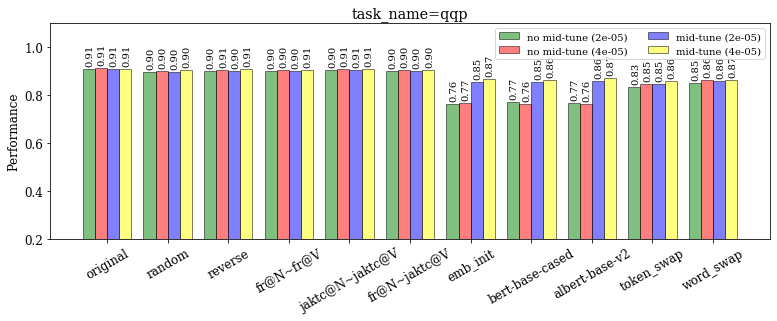

In [350]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use("ggplot")

plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):

    fig = plt.figure(figsize=(10, 3))
    ax = fig.add_axes([0,0,1,1])

    data_1 = []
    data_2 = []
    data_3 = []
    data_4 = []
    for res in results:
        data_1 += [res[0]]
        data_2 += [res[1]]
        data_3 += [res[2]]
        data_4 += [res[3]]
    
    groups = [
        data_1, 
        data_2,
        data_3,
        data_4,
    ]
    group_names = ['no mid-tune (2e-05)', 'no mid-tune (4e-05)', 'mid-tune (2e-05)', 'mid-tune (4e-05)',]
    groupby_names = [
        "original", "random", "reverse", "fr@N~fr@V", "jaktc@N~jaktc@V", "fr@N~jaktc@V", 
         "emb_init", "bert-base-cased", "albert-base-v2", 
         "token_swap", "word_swap",
    ]

    x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # the label
    width = 0.2  # the width of the bars
    rects0 = ax.bar(x - 1.5*width, groups[0], width, label=group_names[0], edgecolor='black', color="green", alpha=0.5)
    rects1 = ax.bar(x - width/2, groups[1], width, label=group_names[1], edgecolor='black', color="red", alpha=0.5)
    rects2 = ax.bar(x + width/2, groups[2], width, label=group_names[2], edgecolor='black', color="blue", alpha=0.5)
    rects3 = ax.bar(x + 1.5*width, groups[3], width, label=group_names[3], edgecolor='black', color="yellow", alpha=0.5)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(groupby_names, rotation=30)
    ax.legend(
        loc='upper right', fontsize=10, ncol=2
    )
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(0.02+ rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, rotation=90)

    autolabel(rects0)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    
    fig.tight_layout()

    ax.set_facecolor("white")
    plt.title(f"task_name={task_name}")
    plt.ylim(0.2,1.1)
    plt.show()
    # plt.savefig("../../data-files-updated/Analysis-Result/action_sequence_length",dpi=1000, bbox_inches='tight')